# Exercise A1: IFC Dashboard
41934 Advanced Building Information Modeling (BIM), E23

Kaare G. S. Hansen, s214282 - DTU



## Init, import

In [1]:
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import ifcopenshell
import ifcopenshell.util.placement
import ifcopenshell.geom
import ifcopenshell.util.shape
# import ifcopenshell.util.selector


No stream support: No module named 'lark'


In [2]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "png"
pio.renderers.default = "plotly_mimetype+png"

In [3]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Load IFC-file

In [4]:
model_dir = "/Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models"

# model_file = "SkyLab/LLYN - ARK.ifc"
# model_file = "SkyLab/LLYN - STRU.ifc"
# model_file = "SkyLab/LLYN - KON.ifc"
# model_file = "SkyLab/LLYN - KON.ifc"
model_file = "SkyLab/LLYN - ARK - space.ifc"
model_path = os.path.join(model_dir, model_file)
# model_path = model_dir + '/' + model_file

# model_path = "/Users/Kaare/Desktop/highRiseTest.ifc"

print(f"File path: {model_path}")

model = ifcopenshell.open(model_path)
ModelHasColor = True
print(f"Model schema: {model.schema}")

File path: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab/LLYN - ARK - space.ifc
Model schema: IFC2X3


## Select data

In [5]:
storeys = dict()
for storey in model.by_type('IfcBuildingStorey'):
    storeys[storey.GlobalId] = storey
    print(storey.Name)

KL_Kælder
ES_Stue
E1_1. Sal
E2_2. Sal
E3_3. Sal
E4_4. Sal


In [6]:
slabs = model.by_type('IfcSlab')
beams = model.by_type('IfcBeam')
columns = model.by_type('IfcColumn')
walls = model.by_type('IfcWall')

entities = [*slabs, *beams, *columns, *walls]

### Materials

In [21]:
display(pd.DataFrame([material.get_info() for material in model.by_type('IfcMaterial')]).head(-1))
# model.by_type('IfcMaterial')

,id,type,Name
0,81501,IfcMaterial,RM_Væg_Beton_Element
1,85321,IfcMaterial,RM_Væg_Beton_Element Check
2,85802,IfcMaterial,RM_Væg_Gipsplade
3,85812,IfcMaterial,RM_Batt isolering
4,86626,IfcMaterial,Door interior - Panel
...,...,...,...
69,3841388,IfcMaterial,Skylight Composite
70,4019356,IfcMaterial,Fixtures - Plastic - White
71,4024536,IfcMaterial,"Steel, sort"
72,4025399,IfcMaterial,Elefantrist


In [8]:
material_names = [
    'Concrete',
    'RM_Dæk_Beton_Element',
    'RM_Væg_Beton_Element',
    'RM_Væg_Beton_Element Check',
]

### Select elements of interest

Elements of interest are elements that consists of mentioned materials

In [9]:
slab_DE = []

df = pd.DataFrame(
    #[[storey.GlobalId, storey.Name, 0] for storey in model.by_type('IfcBuildingStorey')],
    # index='Storey GUID',
    columns=['GUID', 'Name', 'Type', 'Class', 'Storey GUID', 'Storey',
             'Count', 'NetVolume', 'Material', 'Ignore']
)

for entity in entities:
    info = entity.get_info()
    objectType = info['ObjectType']

    # if not 'Floor:DE' in objectType: continue
    if 'Floor:DE' in objectType: slab_DE.append(entity)

    # Only select elements of these materials
    materials = ifcopenshell.util.element.get_materials(entity)
    validMaterial = False
    for material in materials:
        if material.get_info()['Name'] in material_names:
            validMaterial = True
    
    if not validMaterial: continue

    #print(info)

    psets = ifcopenshell.util.element.get_psets(entity)
    #print(psets.keys())
    #Pset_SlabCommon = psets['Pset_SlabCommon']
    #print("Reference", Pset_SlabCommon['Reference'])
    #print(psets)
    # print(pset_ReinforcementBarPitchOfSlab)

    base_quantity = ifcopenshell.util.element.get_pset(entity, 'BaseQuantities')
    pset_quantity = ifcopenshell.util.element.get_pset(entity, 'Pset_QuantityTakeOff')
    container = ifcopenshell.util.element.get_container(entity)

    ignore = True

    if base_quantity:
        if 'NetVolume' in base_quantity: # and 'NetArea' in base_quantity:
            ignore = False

    # print(base_quantity)

    new_row = {
        'GUID': entity.GlobalId,
        'Name': entity.Name,
        'Type': entity.ObjectType,
        'Class': info['type'],
        'Storey GUID': container.GlobalId,
        'Storey': container.Name,
        'Count': 1,
        # 'NetArea': base_quantity['NetArea'] if base_quantity and 'NetArea' in base_quantity else 0,
        'NetVolume': base_quantity['NetVolume'] if base_quantity else 0,
        'Material': str([material.get_info()['Name'] for material in materials]),
        'Ignore': ignore,
        # 'Slabs #': 0,
        }
    df.loc[len(df)] = new_row


In [10]:
df.query("Ignore == True")

,GUID,Name,Type,Class,Storey GUID,Storey,Count,NetVolume,Material,Ignore
12,3T1Jg6h4j1suEys4$UG6Mz,Basic Wall:(21)Beton 200:929072,Basic Wall:(21)Beton 200,IfcWall,0efJ5iWsnCkArvrHuoj9Zy,ES_Stue,1,0.0,['RM_Væg_Beton_Element'],True
70,3mDHig$FP6HQcK4gyCfVAX,Basic Wall:(21)Beton 200:3497893,Basic Wall:(21)Beton 200,IfcWall,0efJ5iWsnCkArvrHuoi7sr,E2_2. Sal,1,0.0,['RM_Væg_Beton_Element'],True
112,2$x3WRXX57SRLFSB6rcK_j,Basic Wall:Væg - sokkel mod jord 300+10:4863787,Basic Wall:Væg - sokkel mod jord 300+10,IfcWall,0efJ5iWsnCkArvrHuoj9Zy,ES_Stue,1,0.0,"['Concrete', 'RM_Batt isolering', 'RM_Batt iso...",True


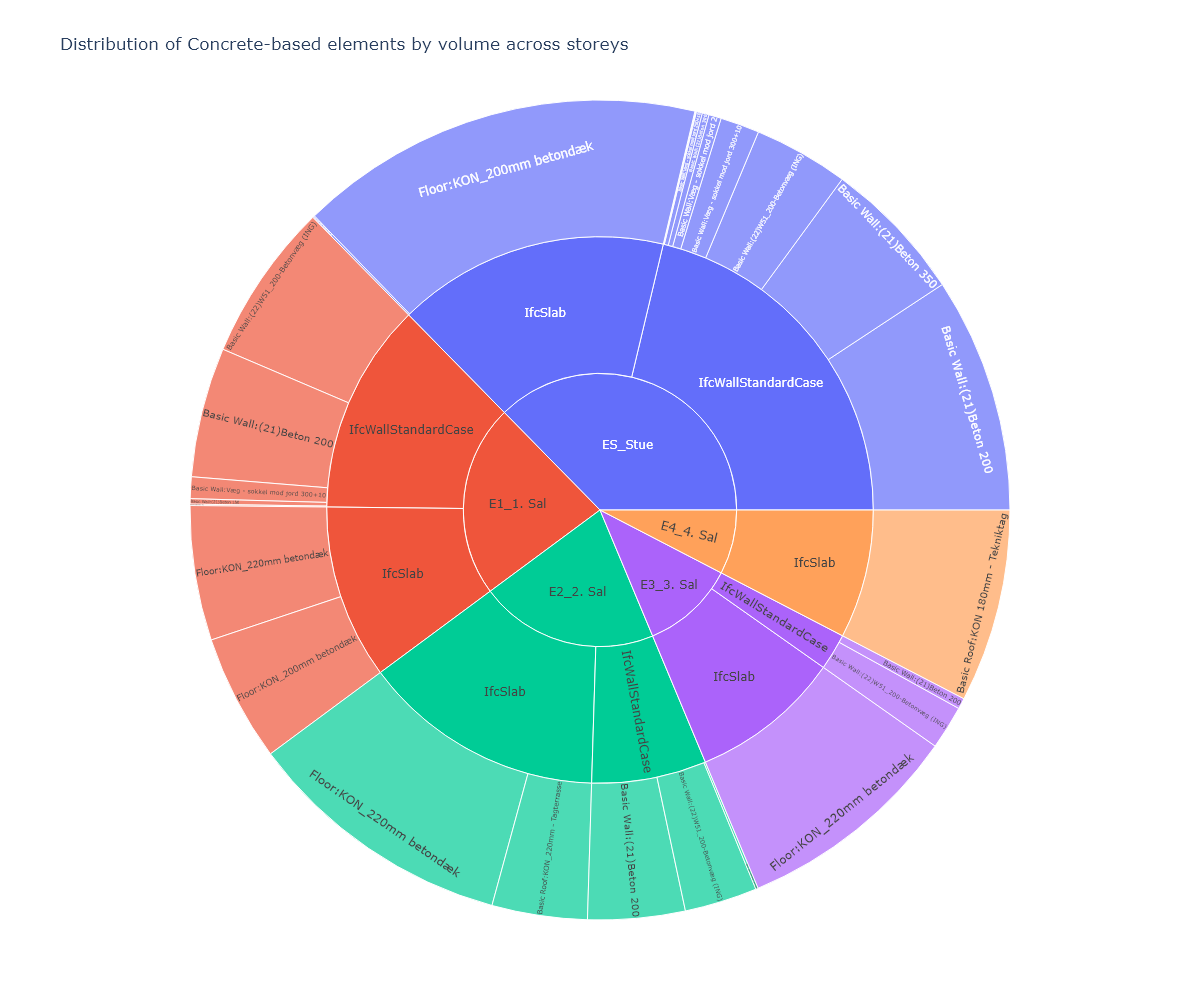

In [11]:
fig = px.sunburst(df.query("Ignore == False"), path=['Storey', 'Class', 'Type'], values='NetVolume',
                  width=1200, height=1000,
                  title="Distribution of Concrete-based elements by volume across storeys",
                  hover_data='Material',
                  )
fig.show()

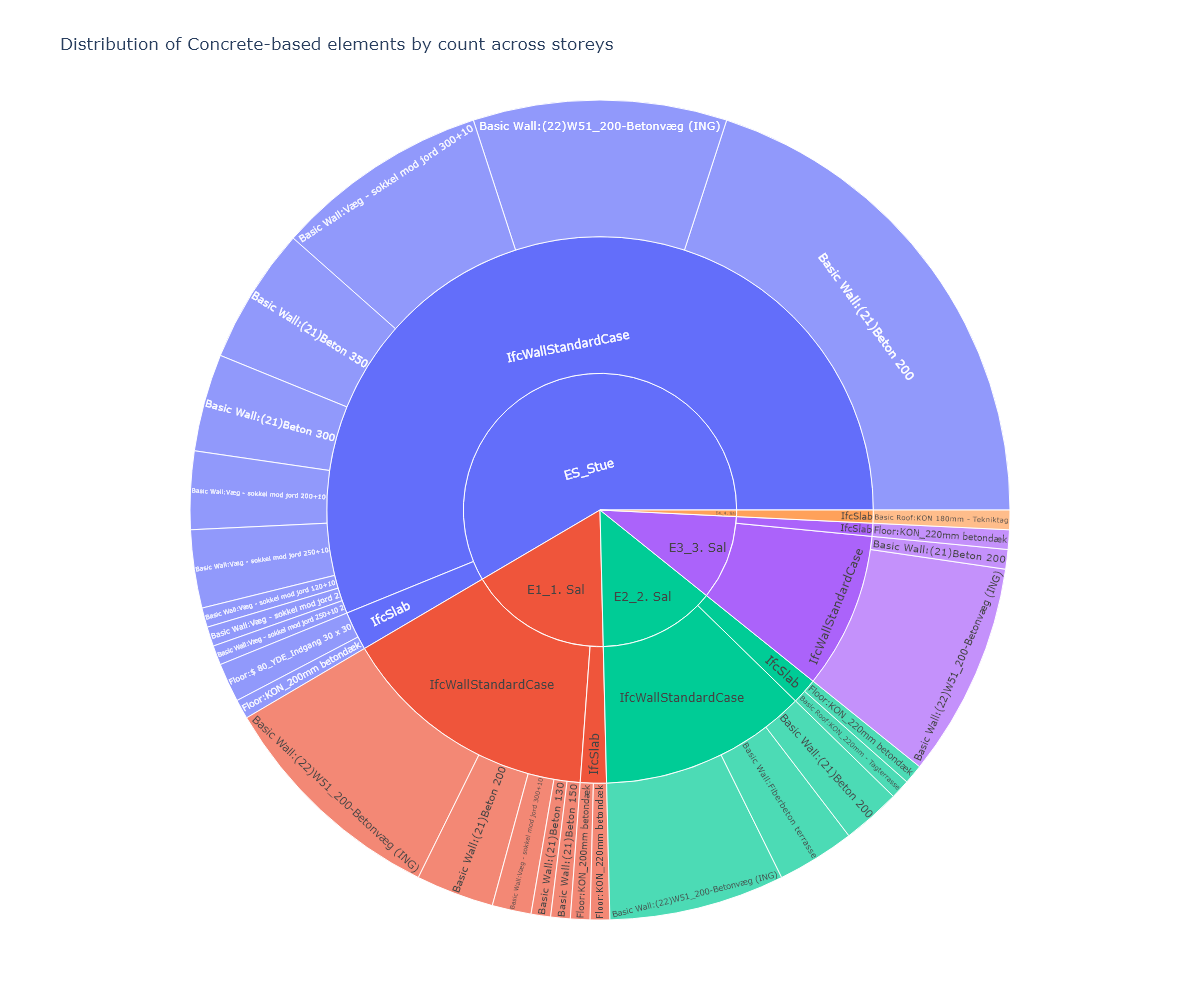

In [12]:
fig = px.sunburst(df.query("Ignore == False"), path=['Storey', 'Class', 'Type'], values='Count',
                  width=1200, height=1000,
                  title="Distribution of Concrete-based elements by count across storeys",
                  hover_data='Material',
                  )
fig.show()

## Functions

### Common

In [13]:
def getElementShapes(entities):
    settings = ifcopenshell.geom.settings()

    element_shapes = []
    for entity in entities:
        try:
            element = entity
            shape = ifcopenshell.geom.create_shape(settings, element)
            element_shapes.append(shape)
        except Exception as e:
            print(element.is_a())
            print(e)

    print(f"Count: ({len(element_shapes)}/{len(entities)})")

    return element_shapes

### Plotly

In [14]:
def plotlyRenderElements(element_shapes):
    verts_list = []
    faces_list = []
    edges_list = []

    fig = go.Figure()

    # for shape in [element_shapes[0]]:
    # for shape in [element_shapes[0], element_shapes[1], element_shapes[2]]:
    for shape in element_shapes:
        geometry = shape.geometry

        # Get basic geometric data
        verts = np.array(geometry.verts)
        verts = np.reshape(verts, (-1, 3))

        faces = np.array(geometry.faces)
        # print(np.shape(faces))
        faces = np.reshape(faces, (-1, 3))

        edges = np.array(geometry.edges)
        edges = np.reshape(edges, (-1, 2))

        # Transform
        matrix = ifcopenshell.util.shape.get_shape_matrix(shape)
        location = matrix[:,3][0:3]

        ones = np.ones(len(verts))
        verts = np.vstack((verts.T, ones)).T

        verts = np.matmul(verts, matrix.T)
        verts = np.array(verts[:,:3], copy=True)

        # verts = verts + location

        # fig.add_trace(go.Mesh3d(
        #         # 8 vertices of a cube
        #         x= verts[:,0],
        #         y= verts[:,1],
        #         z= verts[:,2],
        #         # colorbar_title='z',
        #         # colorscale=[[0, 'gold'],
        #         #             [0.5, 'mediumturquoise'],
        #         #             [1, 'magenta']],
        #         # Intensity of each vertex, which will be interpolated and color-coded
        #         #intensity = np.linspace(0, 1, 8, endpoint=True),
        #         # i, j and k give the vertices of triangles
        #         i = faces[:,0],
        #         j = faces[:,1],
        #         k = faces[:,2],

        #         # showscale=True,
        #         flatshading=True,
        #         lighting=dict(
        #             ambient= 0.8,
        #         )
        #     ))

        # Add to list
        verts_list.append(verts)
        faces_list.append(faces)
        edges_list.append(edges)


    # "Globalize" face indices
    indidces_offset = np.cumsum([len(verts) for verts, faces in zip(verts_list, faces_list)])
    indidces_offset = np.array([0, *indidces_offset[:-1]])

    for i, faces in enumerate(faces_list):
        offset = indidces_offset[i]
        faces_list[i] = faces + offset
    
    verts = np.vstack((verts_list))
    faces = np.vstack((faces_list))

    edges_lines = []
    for i, edges in enumerate(edges_list):
        offset = indidces_offset[i]

        for edge in edges:
            line = np.array([
                verts[edge[0] + offset],
                verts[edge[1] + offset],
                [None, None, None],
            ])

            edges_lines.append(line)

    edges = np.vstack((edges_lines))

    # Makes lines
    lines_list = []
    for face in faces:
        # lines_indices = np.array([
        #     face[0], face[1],
        #     face[0], face[2],
        #     face[1], face[2],
        # ])
        # lines = verts[lines_indices]
        lines = np.array([
            verts[face[0]],
            verts[face[1]],
            verts[face[2]],
            verts[face[0]],
            [None, None, None],
        ])
        lines_list.append(lines)

    lines = np.vstack((lines_list))


    # Make figure trace
    fig.add_traces(go.Mesh3d(
        # 8 vertices of a cube
        x= verts[:,0],
        y= verts[:,1],
        z= verts[:,2],
        # colorbar_title='z',
        # colorscale=[[0, 'gold'],
        #             [0.5, 'mediumturquoise'],
        #             [1, 'magenta']],
        # Intensity of each vertex, which will be interpolated and color-coded
        #intensity = np.linspace(0, 1, 8, endpoint=True),
        # i, j and k give the vertices of triangles
        i = faces[:,0],
        j = faces[:,1],
        k = faces[:,2],
        flatshading=True,
        lighting=dict(
            ambient= 0.8,
            #facenormalsepsilon = 0.001,
        )
    ))

    fig.add_trace(go.Scatter3d(
        x= lines[:,0],
        y= lines[:,1],
        z= lines[:,2],
        mode = 'lines',
    ))

    # fig.add_trace(go.Scatter3d(
    #     x= edges[:,0],
    #     y= edges[:,1],
    #     z= edges[:,2],
    #     mode = 'lines',
    # ))

    fig['layout']['scene']['aspectmode'] = "data"
    fig.update_layout(
        autosize=False,
        width=1800,
        height=1000,
        )
    fig.show()



# plotlyRenderElements(elementShapes)

### Open3D

In [15]:
RenderData = namedtuple('RenderData', ['mesh_list', 'edges_list'] )

def makeRenderData(element_shapes):
    mesh_list = []
    edges_list = []

    for shape in element_shapes:
        geometry = shape.geometry

        verts = np.array(geometry.verts)
        verts = np.reshape(verts, (-1, 3))

        faces = np.array(geometry.faces)
        faces = np.reshape(faces, (-1, 3))

        edges = np.array(geometry.edges)
        edges = np.reshape(edges, (-1, 2))

        #_normals = np.array(geometry.normals)
        #_normals = np.reshape(_normals, (-1, 3))

        #if len(geometry.materials) > 1:
        #    print("Ids:", shape.geometry.material_ids, "styles:", len(geometry.materials))
        
        #print(f"{len(shape.geometry.material_ids)}, {len(shape.geometry.materials)}, {len(verts)}, {len(faces)}")

        vertices = o3d.utility.Vector3dVector(verts)
        triangles = o3d.utility.Vector3iVector(faces)
        #normals = o3d.utility.Vector3dVector(_normals)
        #print("Normals", len(geometry.normals)) # Det ser ikke ud til at der kommer normals fra Ifc-filen

        #transformation_matrix = o3d.utility.Matrix3dVector(shape.transformation.matrix.data)

        mat = np.array(shape.transformation.matrix.data, copy=True)
        
        mat = np.reshape(mat, (-1, 3))
        transform = mat[:3,:].T
        translate = mat[3,:]
        #print(np.shape(mat))
        
        T = np.eye(4)
        T[:3, :3] = transform
        #T[0, 3] = 1

        # print("transformation=", T)
        # print("translation=", translate)

        mesh_np = o3d.geometry.TriangleMesh(vertices, triangles)
        mesh_np.transform(T)
        mesh_np.translate(translate)

        #mesh_np.vertex_normals = normals
        #mesh_np.triangle_normals = normals
        mesh_np.compute_vertex_normals()

        # Colors
        if ModelHasColor:
            colors = np.empty((len(vertices), 3))
            # print(geometry.material_ids)
            for i, material_id in enumerate(geometry.material_ids):
                if material_id == -1: # No material!
                    color = np.array([1.0, 0.0, 1.0])
                else:
                    material = geometry.materials[material_id]
                    color = np.array(material.diffuse)
                
                face = faces[i]

                for vertexIndex in face:
                    colors[vertexIndex] = color

            mesh_np.vertex_colors = o3d.utility.Vector3dVector(colors)
            assert np.shape(colors) == np.shape(vertices)

        edges = o3d.utility.Vector2iVector(edges)
        edges_np = o3d.geometry.LineSet(vertices, edges)
        edges_np.transform(T)
        edges_np.translate(translate)

        mesh_list.append(mesh_np)
        edges_list.append(edges_np)

    print(f"Mesh list length: {len(mesh_list)}")
    return RenderData(mesh_list, edges_list)

In [16]:
def runVisualization(data: RenderData):
    #print(np.asarray(mesh_np.triangle_normals))
    print("Displaying mesh made using numpy ...")
    mesh_origin = o3d.geometry.TriangleMesh.create_coordinate_frame()
    data.mesh_list.append(mesh_origin)
    o3d.visualization.draw_geometries(data.mesh_list + data.edges_list)
    # o3d.visualization.draw_geometries(data.edges_list)

## Render entities

In [17]:
entities_render = []
for guid in list(df.query("Ignore == False")['GUID']):
    entities_render.append(model.by_guid(guid))

In [18]:
elementShapes = getElementShapes(entities_render)
print(f"Created element shapes")
# renderData = makeRenderData([elementShapes[0]])
renderData = makeRenderData(elementShapes)
print(f"Created render data")

Count: (130/130)
Created element shapes
Mesh list length: 130
Created render data


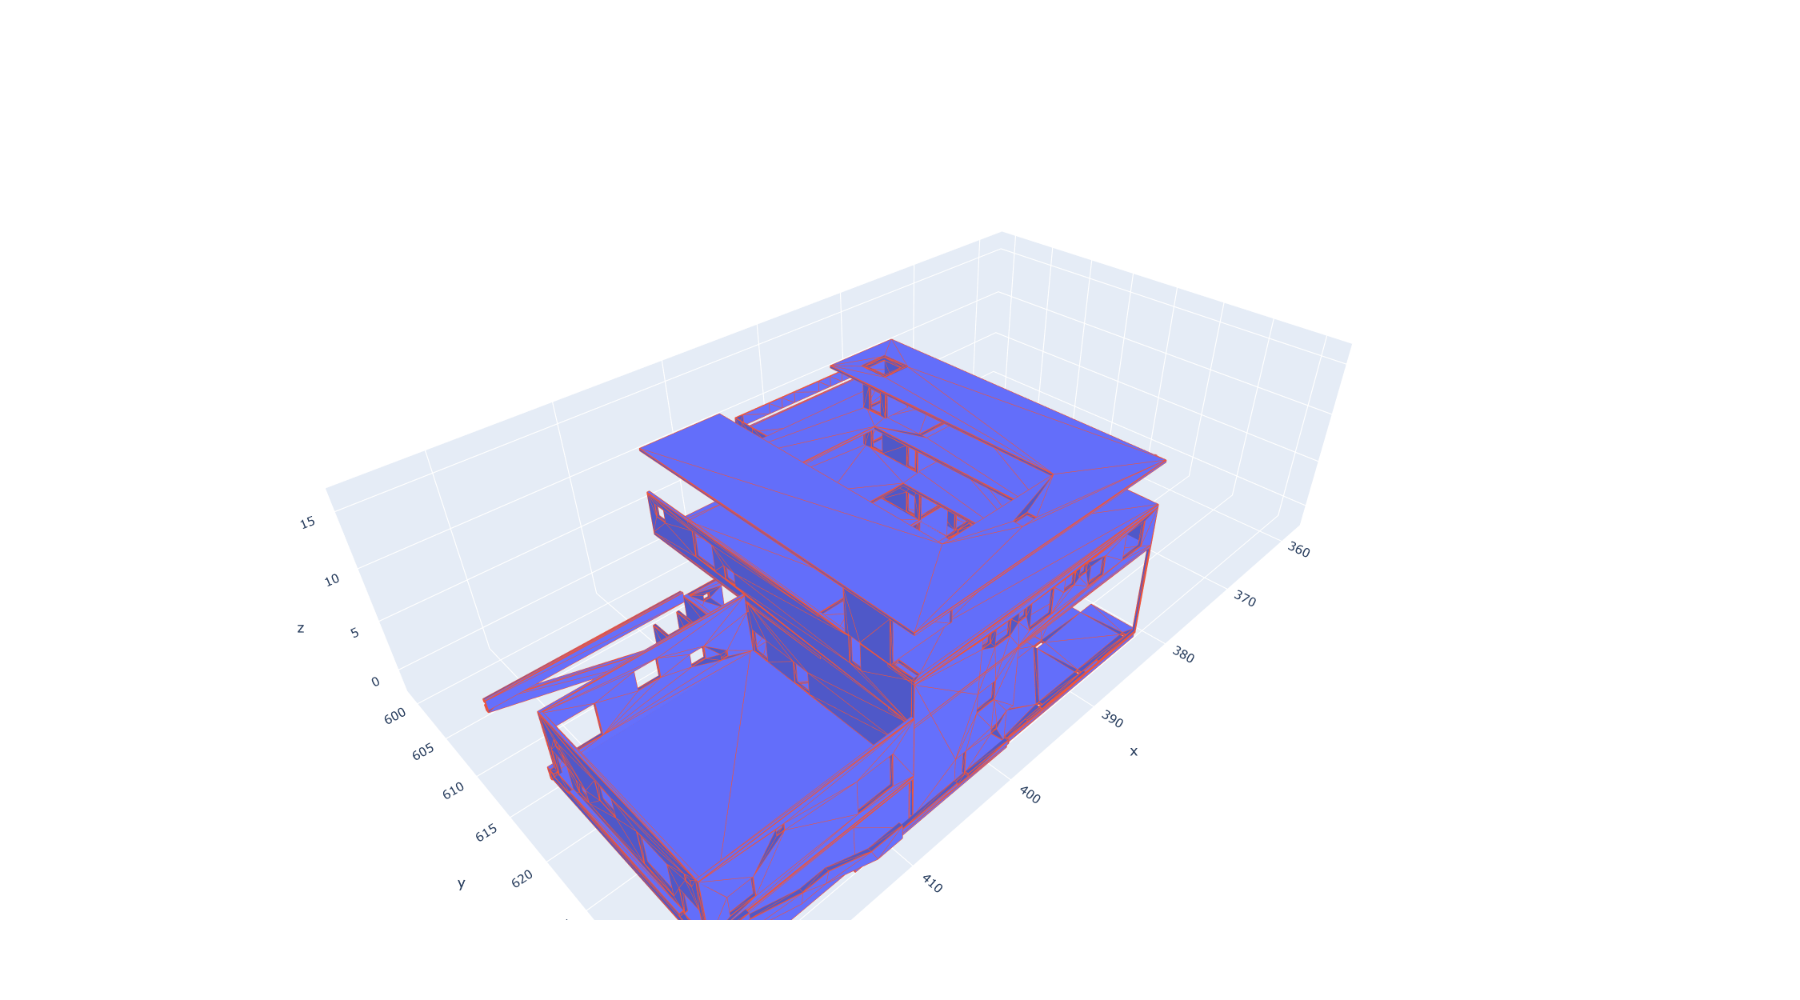

In [19]:
plotlyRenderElements(elementShapes)

In [20]:
if True:
    runVisualization(renderData)
    print(f"Visualization exited")

Displaying mesh made using numpy ...
Visualization exited
